In [6]:
import sisl
import pandas as pd
import csv
import ast

from pathlib import Path
from tqdm import tqdm

# Read the dataset using SISL
path= Path('../dataset')

# Get all subdirectories (atom types)
n_atoms_paths = list(path.glob('*/'))

# Then all structures
i=0
structure_paths = [list(n_atoms_paths[i].glob('*/')) for i in range(len(n_atoms_paths))]
structure_paths = [item for sublist in structure_paths for item in sublist]

# Create Padnas DataFrame
columns = ["n_atoms", "atomic_number", "atomic_symbol", "atomic_positions", "lattice_nsc", "lattice_origin", "lattice_vectors", "boundary_condition"]
df = pd.DataFrame(columns=columns)
for structure in tqdm(structure_paths):
    file = sisl.get_sile(structure / "aiida.HSX")
    geometry = file.read_geometry()
    lattice_vectors = geometry.lattice

    # Get atom symbols
    atomic_symbols = []
    for atom in geometry.atoms:
        atomic_symbols.append(atom.symbol)

    row_dict = {
        "n_atoms": len(geometry),
        "atomic_number": geometry.atoms.Z,
        "atomic_symbol": atomic_symbols,
        "atomic_positions": geometry.xyz,
        "lattice_nsc": lattice_vectors.nsc,
        "lattice_origin": lattice_vectors.origin,
        "lattice_vectors": lattice_vectors.cell,
        "boundary_condition": lattice_vectors.boundary_condition
    }

    df = pd.concat([df, pd.DataFrame([row_dict])], ignore_index=True)
    
df.to_pickle("dataset.pkl")

100%|██████████| 1311/1311 [00:01<00:00, 847.94it/s]


In [8]:
# Read the dataset back
df = pd.read_pickle("dataset.pkl")
df.tail()

,n_atoms,atomic_number,atomic_symbol,atomic_positions,lattice_nsc,lattice_origin,lattice_vectors,boundary_condition
1306,3,"[5, 6, 7]","[B, C, N]","[[3.3844585986999998, 0.0, 0.0], [3.2873668683...","[5, 5, 7]","[0.0, 0.0, 0.0]","[[3.5999899999999996, 0.0, 0.0], [0.0, 3.59998...","[[2, 2], [2, 2], [2, 2]]"
1307,3,"[7, 7, 6]","[N, N, C]","[[2.9851477079, 0.6391782245, 0.0], [0.2881431...","[5, 5, 5]","[0.0, 0.0, 0.0]","[[3.5999899999999996, 0.0, 0.0], [0.0, 3.59998...","[[2, 2], [2, 2], [2, 2]]"
1308,3,"[5, 6, 7]","[B, C, N]","[[3.3844585986999998, 0.0, 0.0], [1.938954614,...","[5, 5, 5]","[0.0, 0.0, 0.0]","[[3.5999899999999996, 0.0, 0.0], [0.0, 3.59998...","[[2, 2], [2, 2], [2, 2]]"
1309,3,"[5, 6, 7]","[B, C, N]","[[3.3844585986999998, 0.0, 0.0], [2.3964413432...","[5, 5, 5]","[0.0, 0.0, 0.0]","[[3.5999899999999996, 0.0, 0.0], [0.0, 3.59998...","[[2, 2], [2, 2], [2, 2]]"
1310,3,"[7, 7, 6]","[N, N, C]","[[2.9851477079, 0.6391782245, 0.0], [0.3007791...","[5, 5, 5]","[0.0, 0.0, 0.0]","[[3.5999899999999996, 0.0, 0.0], [0.0, 3.59998...","[[2, 2], [2, 2], [2, 2]]"


In [9]:
# Print some stats.

# Unique atom types
unique_atom_types = []
for row in df["atomic_number"]:
    for atom_type in row:
        if atom_type not in unique_atom_types:
            unique_atom_types.append(atom_type)

# Unique atom symbols
unique_atom_symbols = []
for row in df["atomic_symbol"]:
    for atom_type in row:
        if atom_type not in unique_atom_symbols:
            unique_atom_symbols.append(atom_type)

print(f"Analyzed {len(df)} elements. Found:")
print(unique_atom_types)
print(unique_atom_symbols)

Analyzed 1311 elements. Found:
[7, 6, 5]
['N', 'C', 'B']


There are some carbons. How many of them?

In [31]:
n_carbon = df["atomic_number"].apply(lambda x: 6 in x).sum()
print(f"There are {n_carbon}/{len(df)} samples with Carbon atoms.")

There are 682/1311 samples with Carbon atoms.


This is more than half the dataset. Not negligible.

What is the distribution of the carbon atoms?

Text(0, 0.5, 'Number of structures with Carbon atoms')

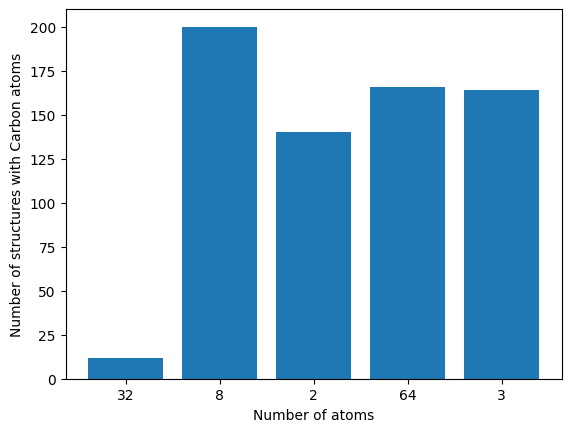

In [54]:
import matplotlib.pyplot as plt

n_atoms = df["n_atoms"].drop_duplicates()
counts = [df[df["n_atoms"] == i]["atomic_number"].apply(lambda x: 6 in x).sum() for i in n_atoms.to_list()]
x_labels = [str(i) for i in n_atoms.to_list()]
plt.bar(x_labels, counts)
plt.xlabel("Number of atoms")
plt.ylabel("Number of structures with Carbon atoms")

# Where is the perfect crystal?

In [8]:
# === List of paths to all structures ===
import random
import yaml
from pathlib import Path
import sisl

def load_config(path="../config.yaml"):
    with open(path, "r") as f:
        return yaml.safe_load(f)
    
def flatten(xss):
    return [x for xs in xss for x in xs]


parent_path = Path('../dataset')
n_atoms_paths = list(parent_path.glob('*/'))
paths = []
for n_atoms_path in n_atoms_paths:
    structure_paths = list(n_atoms_path.glob('*/'))
    paths.append(structure_paths)
paths = flatten(paths)

random.seed(42)
random.shuffle(paths)

# Search the crystal with no carbon atoms
count = 0
for path in paths:
    file = sisl.get_sile(path / "aiida.fdf")
    geometry = file.read_geometry()
    if 6 not in geometry.atoms.Z and len(geometry.atoms.Z) == 8:
        print(f"Found a structure with no Carbon atoms: {path}")
        count += 1


print(f"Found {count} structures with no Carbon atoms.")

Found a structure with no Carbon atoms: ../dataset/SHARE_OUTPUTS_8_ATOMS/907c-7487-46bd-8ad3-65b031f7f12b
Found a structure with no Carbon atoms: ../dataset/SHARE_OUTPUTS_8_ATOMS/74f6-ada8-4fcd-b69f-4ca3b0ddc30e
Found a structure with no Carbon atoms: ../dataset/SHARE_OUTPUTS_8_ATOMS/e84c-005c-4672-8d63-61876b569f15
Found a structure with no Carbon atoms: ../dataset/SHARE_OUTPUTS_8_ATOMS/8bfa-ca36-41f1-a041-14ad17494d59
Found a structure with no Carbon atoms: ../dataset/SHARE_OUTPUTS_8_ATOMS/5721-4d12-41f2-9f31-f7ee4fcf1096
Found a structure with no Carbon atoms: ../dataset/SHARE_OUTPUTS_8_ATOMS/807c-f894-4054-8ea4-da19dab86b43
Found a structure with no Carbon atoms: ../dataset/SHARE_OUTPUTS_8_ATOMS/4afc-f1fa-44f8-b159-50cdb0c2020b
Found a structure with no Carbon atoms: ../dataset/SHARE_OUTPUTS_8_ATOMS/8fb0-5187-4844-ab5b-f005e5a16194
Found a structure with no Carbon atoms: ../dataset/SHARE_OUTPUTS_8_ATOMS/085c-aa27-45ef-b057-4291c5609360
Found a structure with no Carbon atoms: ../dat

In [11]:
# Ok. There are several structures which are crystals with no Carbon atoms. Then, what is different in these structures?
paths = [
    Path("../dataset/SHARE_OUTPUTS_8_ATOMS/907c-7487-46bd-8ad3-65b031f7f12b"),
    Path("../dataset/SHARE_OUTPUTS_8_ATOMS/74f6-ada8-4fcd-b69f-4ca3b0ddc30e")
]

for i, path in enumerate(paths):
    print(f"Analyzing structure", i+1)
    file = sisl.get_sile(path / "aiida.fdf")
    file.plot.geometry(axes="xz")

Analyzing structure 1
Analyzing structure 2


In [15]:
file = sisl.get_sile(paths[0] / "aiida.fdf")
file.plot.geometry(axes="xyz")

INFO	Task(Task-4) nodify.node.140575592980432:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140575593935792:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140575603355488:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140575592983840:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140575592691088:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140575592690128:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140575593935792:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575603355488:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575592983840:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575592691088:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575592690128:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

INFO	Task(Task-4) nodify.node.140575592980432:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575593935792:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575603355488:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575592983840:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575592691088:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575592690128:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575593935792:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575603355488:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575592983840:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575592691088:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575592690128:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575593935792:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.nod

In [14]:
file = sisl.get_sile(paths[1] / "aiida.fdf")
file.plot.geometry(axes="xyz")

INFO	Task(Task-4) nodify.node.140575594580160:node.py:get()- Evaluated because inputs changed.


INFO	Task(Task-4) nodify.node.140575603497520:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140575594587648:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140575594576592:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140575594592256:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140575594583376:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-4) nodify.node.140575603497520:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575594587648:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575594576592:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575594592256:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575594583376:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575603497520:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575603

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

INFO	Task(Task-4) nodify.node.140575594580160:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575603497520:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575594587648:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575594576592:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575594592256:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575594583376:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575603497520:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575594587648:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575594576592:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575594592256:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575594583376:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.node.140575603497520:node.py:get()- No need to evaluate
INFO	Task(Task-4) nodify.nod